# Setting up

In [16]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from footbot.data.utils import set_up_bigquery, run_query

In [6]:
pd.set_option('max_colwidth', 60)
pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

In [7]:
client = set_up_bigquery('../../secrets/service_account.json')

# Getting data

In [83]:
sql = '''
SELECT
  element_all,
  safe_web_name,
  safe_team_name,
  element_type,
  AVG(goals_scored) / AVG(minutes) AS goals_scored_per_minute,
  AVG(assists) / AVG(minutes) AS assists_per_minute,
  AVG(goals_conceded) / AVG(minutes) AS goals_conceded_per_minute,
FROM (
  SELECT
    e.element_all,
    FIRST_VALUE(e.element_type) OVER(PARTITION BY e.element_all ORDER BY kickoff_time DESC) AS element_type,
    FIRST_VALUE(e.safe_team_name) OVER(PARTITION BY e.element_all ORDER BY kickoff_time DESC) AS safe_team_name,
    e.safe_web_name,
    eg.*,
    DENSE_RANK() OVER(PARTITION BY e.element_all ORDER BY kickoff_time DESC) AS event_order
  FROM
    `footbot-001.fpl.element_gameweeks_all` AS eg
  INNER JOIN
    `footbot-001.fpl.elements_all` AS e
  ON
    eg.element = e.element
    AND eg.season = e.season
  INNER JOIN
    `footbot-001.fpl.elements_all` AS ce
  ON
    e.element_all = ce.element_all
    AND ce.season = '2021'
  WHERE
    minutes > 0 )
WHERE
  event_order <= 38
  AND element_type != 1
GROUP BY
  1,
  2,
  3,
  4
HAVING
  AVG(minutes) >= 60
'''

In [84]:
df = run_query(sql, client)

df.sample(10)

,element_all,safe_web_name,safe_team_name,element_type,goals_scored_per_minute,assists_per_minute,goals_conceded_per_minute
27,1216,sessegnon,spurs,3,0.000816,0.002448,0.024480
75,474,guilbert,aston villa,2,0.000000,0.000981,0.017664
217,972,cash,aston villa,2,0.000000,0.001295,0.016839
1,902,trezeguet,aston villa,3,0.002606,0.001303,0.015204
285,1053,redmond,southampton,3,0.002149,0.001535,0.019030
191,1085,norwood,sheffield utd,3,0.000324,0.000971,0.011654
93,308,ceballos,arsenal,3,0.000000,0.001302,0.012587
283,345,sanchez,spurs,2,0.000311,0.000621,0.014601
171,498,wijnaldum,liverpool,3,0.001325,0.000000,0.009272
127,695,stones,man city,2,0.000000,0.000000,0.011115


In [85]:
len(df)

301

# Profiling data

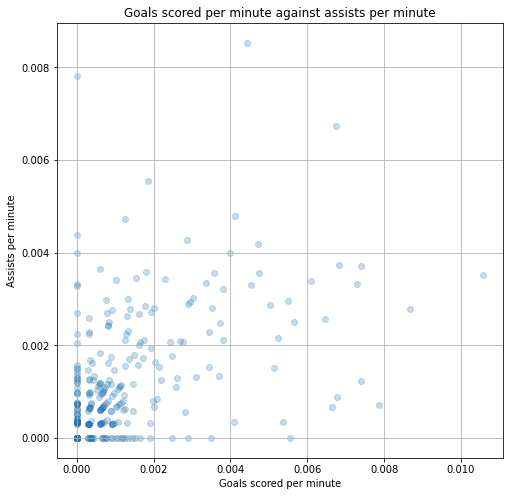

In [93]:
plt.figure(figsize=(8, 8))
plt.scatter(
    df['goals_scored_per_minute'],
    df['assists_per_minute'],
    alpha=0.25
)
plt.title('Goals scored per minute against assists per minute')
plt.xlabel('Goals scored per minute')
plt.ylabel('Assists per minute')
plt.grid()
plt.show()

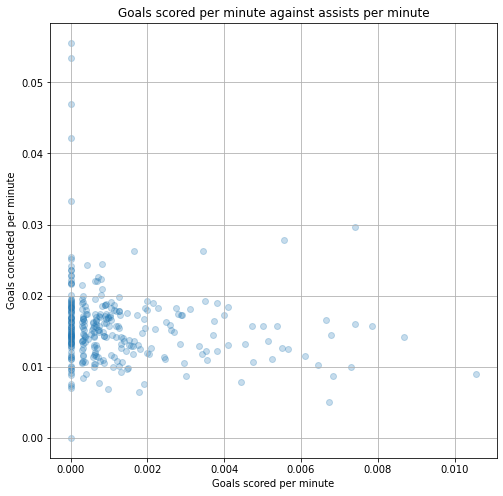

In [94]:
plt.figure(figsize=(8, 8))
plt.scatter(
    df['goals_scored_per_minute'],
    df['goals_conceded_per_minute'],
    alpha=0.25
)
plt.title('Goals scored per minute against assists per minute')
plt.xlabel('Goals scored per minute')
plt.ylabel('Goals conceded per minute')
plt.grid()
plt.show()

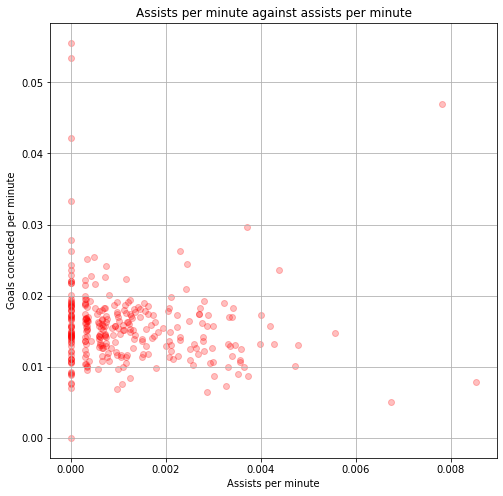

In [112]:
plt.figure(figsize=(8, 8))
plt.scatter(
    df['assists_per_minute'],
    df['goals_conceded_per_minute'],
    alpha=0.25,
)
plt.title('Assists per minute against assists per minute')
plt.xlabel('Assists per minute')
plt.ylabel('Goals conceded per minute')
plt.grid()
plt.show()

# Modelling

In [113]:
kmeans = KMeans(
    n_clusters=3,
    n_init=50,
    max_iter=1000,
    random_state=0
).fit(
    df[['goals_scored_per_minute', 'assists_per_minute',]]
)

In [114]:
df['cluster'] = kmeans.labels_

In [115]:
kmeans.cluster_centers_

array([[0.00185539, 0.00255214],
       [0.00047393, 0.00052412],
       [0.0061118 , 0.00295979]])

In [120]:
df[df['cluster'] == 1].describe()

,element_all,element_type,goals_scored_per_minute,assists_per_minute,goals_conceded_per_minute,cluster
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.0
mean,728.903846,2.322115,0.000474,0.000524,0.015988,1.0
std,403.790124,0.498395,0.000537,0.000505,0.005868,0.0
min,2.000000,2.000000,0.000000,0.000000,0.000000,1.0
25%,419.250000,2.000000,0.000000,0.000000,0.013000,1.0
50%,687.500000,2.000000,0.000329,0.000357,0.015562,1.0
75%,1068.250000,3.000000,0.000747,0.000884,0.017967,1.0
max,1424.000000,4.000000,0.002887,0.002237,0.055556,1.0


In [123]:
df[df['cluster'] == 2].sample(20)

,element_all,safe_web_name,safe_team_name,element_type,goals_scored_per_minute,assists_per_minute,goals_conceded_per_minute,cluster
34,663,dunne,burnley,2,0.005556,0.000000,0.027778,2
10,1142,aubameyang,arsenal,3,0.005133,0.001510,0.013587,2
88,116,martial,man utd,3,0.006102,0.003390,0.011525,2
128,1012,antonio,west ham,3,0.005022,0.002869,0.015782,2
250,613,rodriguez,everton,3,0.003995,0.003995,0.017310,2
269,804,de bruyne,man city,3,0.004438,0.008535,0.007853,2
278,1088,watkins,aston villa,4,0.007407,0.001235,0.016049,2
124,212,fernandes,man utd,3,0.006740,0.006740,0.005055,2
50,258,pulisic,chelsea,3,0.004722,0.004197,0.015740,2
37,221,wilson,bournemouth,4,0.007407,0.003704,0.029630,2


# Profiling clusters

In [126]:
cluster_colour = {
    0: 'red',
    1: 'blue',
    2: 'green'
}

df['cluster_colour'] = df['cluster'].apply(lambda x: cluster_colour[x])

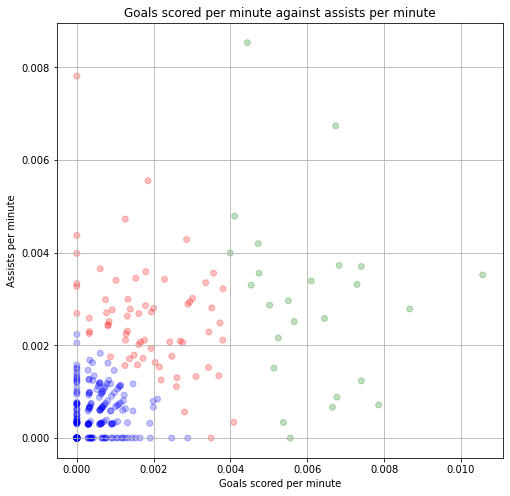

In [127]:
plt.figure(figsize=(8, 8))
plt.scatter(
    df['goals_scored_per_minute'],
    df['assists_per_minute'],
    alpha=0.25,
    color = df['cluster_colour']
)
plt.title('Goals scored per minute against assists per minute')
plt.xlabel('Goals scored per minute')
plt.ylabel('Assists per minute')
plt.grid()
plt.show()